# [1] Assignment 4: Apply Naive Bayes

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from prettytable import PrettyTable
from textblob import TextBlob
import scipy
import math

sns.set(font_scale = 1.4)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('database.sqlite')
data = pd.read_sql_query('select * from Reviews where score != 3', con)
def segregate(x):
    if x < 3:
        return 0
    return 1
data.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [3]:
score_list = data['Score']
segregated_scores = score_list.map(segregate)
data['Score'] = segregated_scores

In [4]:
#Deduplication process
#Sorting data based on time for time based splitting
sorted_data = data.sort_values('Time', axis=0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')
final_data = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep = 'first', inplace = False)
final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
#Text preprocessing stemming, stop word removal
stop_wrds = nltk.corpus.stopwords.words('english')
sno_stem = nltk.stem.SnowballStemmer('english')
def clearhtml(sentence):
    cleared_sentence = re.sub('<.*?>', ' ', sentence)
    return cleared_sentence
def clearpunc(sentence):
    cleared_sentence = re.sub('[?|!|\'|"|#]', '', sentence)
    cleared_sentence = re.sub('[.|,|)|(|\|/)]', ' ',cleared_sentence)
    return cleared_sentence
i = 0
final_list_of_cleaned_reviews = []
cleaned_review_string = ''
for sent in tqdm(final_data['Text'].values):
    cleaned_review_word_list = []
    sent = clearhtml(sent)
    for word in sent.split():
        for cleaned_word in clearpunc(word).split():
            if((cleaned_word.isalpha()) & (len(cleaned_word)>2)):
                if(cleaned_word.lower() not in stop_wrds):
                    stemed_word = (sno_stem.stem(cleaned_word.lower())).encode('utf8')
                    cleaned_review_word_list.append(stemed_word)
                else:
                    continue
            else:
                continue
    cleaned_review_string = b" ".join(cleaned_review_word_list)
    final_list_of_cleaned_reviews.append(cleaned_review_string)
    i += 1
final_data['Cleaned_Text'] = final_list_of_cleaned_reviews
final_data['Cleaned_Text'] = final_data['Cleaned_Text'].str.decode('utf8')

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:46<00:00, 620.63it/s]


In [5]:
final_data = final_data.head(100000)
#Now we will perform time based slicing as we have already sorted the data based on time in ascending order
x_train_raw = final_data['Cleaned_Text'][0:60000]
y_train = final_data['Score'][0:60000]
x_cv_raw = final_data['Cleaned_Text'][60000:80000]
y_cv = final_data['Score'][60000:80000]
x_test_raw = final_data['Cleaned_Text'][80000:100000]
y_test = final_data['Score'][80000:100000]
#Some common initializations that are used in whole of the assingnment
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]
log_alphas = []
for alpha in alphas:
    log_alphas.append(math.log(alpha))

# Applying Multinomial Naive Bayes

## BOW

### Trainning

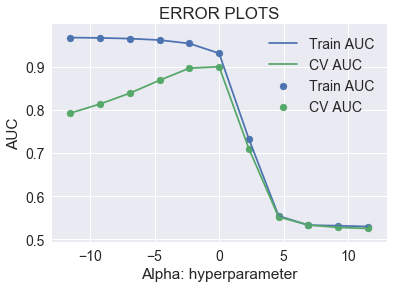

In [6]:
count_vect = CountVectorizer()
count_vect.fit(x_train_raw.values)
x_train = count_vect.transform(x_train_raw.values)
x_cv = count_vect.transform(x_cv_raw)
train_auc = []
cv_auc = []
#performing simple cross-validation
for alpha in alphas:
    clf = MultinomialNB(alpha = alpha)
    clf.fit(x_train, y_train)
    y_train_pred = []
    y_cv_pred = []
    for i in range(0, x_train.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(x_train[i:i+1000,:])[:,1])
    for i in range(0, x_cv.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(x_cv[i:i+1000,:])[:,1])
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alphas, train_auc, label='Train AUC')
plt.scatter(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.scatter(log_alphas, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [7]:
optimal_alpha = 1
bow_alpha = optimal_alpha

### Testing

The accuracy for k = 1 using simple crossvalidation for BOW is 90.5


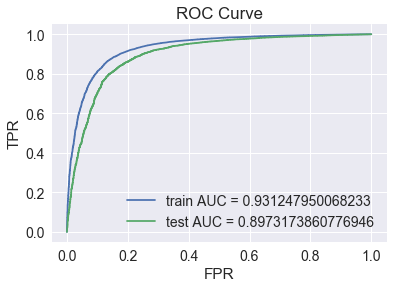

Confusion Matrix : 


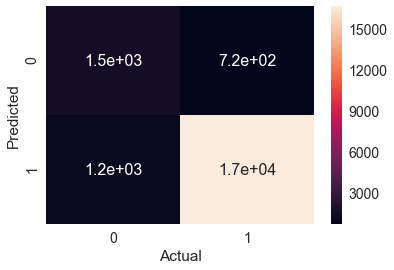

In [8]:
clf_for_optimal_alpha = MultinomialNB(alpha = optimal_alpha)
clf_for_optimal_alpha.fit(x_train, y_train)
x_test = count_vect.transform(x_test_raw)
y_test_pred = []
y_train_pred_proba = []
y_test_pred_proba = []
for i in range(0, x_train.shape[0], 1000):
    y_train_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_train[i:i+1000])[:,1]) # To build ROC curve
for i in range(0,x_test.shape[0], 1000):
    y_test_pred.extend(clf_for_optimal_alpha.predict(x_test[i:i+1000,:])) # To find Accuracy
    y_test_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_test[i:i+1000])[:,1]) # To build ROC curve

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
acc = accuracy_score(y_test,y_test_pred)*100.0
print('The accuracy for k = {} using simple crossvalidation for BOW is {}'.format(optimal_alpha, acc))

bow_train_auc = auc(train_fpr, train_tpr)
bow_test_auc = auc(test_fpr, test_tpr)
plt.plot(train_fpr, train_tpr, label = 'train AUC = '+str(bow_train_auc))
plt.plot(test_fpr, test_tpr, label = 'test AUC = '+str(bow_test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

print('Confusion Matrix : ')
matrix = confusion_matrix(y_test,y_test_pred).T
ax = sns.heatmap(matrix, annot = True, annot_kws = {'size' : 16})
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

### Top 10 important features of positive class

In [9]:
top10_indexes = clf_for_optimal_alpha.feature_log_prob_[1].argsort()[-10:][::-1]
list_of_features = count_vect.get_feature_names()
print('Feature : Log Probability')
for index in top10_indexes:
    print('{} : {}'.format(list_of_features[index], clf_for_optimal_alpha.feature_log_prob_[1][index]))

Feature : Log Probability
like : -4.468583063969319
tast : -4.490367013610863
tea : -4.60875423676965
good : -4.640206043002321
flavor : -4.667729461221892
great : -4.6723448112558135
love : -4.754433232015623
use : -4.796950758006625
one : -4.831832413651776
product : -4.867026466632408


### Top 10 important features of negative class

In [10]:
top10_indexes = clf_for_optimal_alpha.feature_log_prob_[0].argsort()[-10:][::-1]
print('Feature : Log Probability')
for index in top10_indexes:
    print('{} : {}'.format(list_of_features[index], clf_for_optimal_alpha.feature_log_prob_[0][index]))

Feature : Log Probability
tast : -4.288275992348506
like : -4.3863833767738925
product : -4.484301997621333
one : -4.787237284089253
flavor : -4.8990781599625866
would : -4.963803789342822
tri : -4.975347204849026
good : -5.078970490111133
tea : -5.257491885854814
use : -5.267582788836777


### Feature Engineering

Now I will be adding following 2 new features :
1. Taking length of reviews as another feature.
2. Detecting the sentiment of the Summary of the review using the textblob library

In [11]:
def segregate2(x):
    if x < 0:
        return 0
    return 1

In [12]:
final_data['Length_of_Cleaned_Text'] = final_data['Cleaned_Text'].apply(lambda x : len(x.split()))
final_data['Sentiment'] = final_data['Summary'].apply(lambda x: TextBlob(x).sentiment[0]).map(segregate2)
final_data[['Score', 'Sentiment']].head(10)

,Score,Sentiment
138706,1,1
138683,1,1
417839,1,1
417859,1,1
417838,1,1
417927,1,1
417847,0,1
70688,1,1
346141,1,1
417883,1,1


In [13]:
final_data[['Cleaned_Text', 'Length_of_Cleaned_Text']].head(10)

,Cleaned_Text,Length_of_Cleaned_Text
138706,witti littl book make son laugh loud recit car...,35
138683,rememb see show air televis year ago child sis...,30
417839,beetlejuic well written movi everyth excel act...,13
417859,twist rumplestiskin captur film star michael k...,20
417838,beetlejuic excel funni movi keaton hilari wack...,26
417927,one movi movi collect fill comedi action whate...,11
417847,alway enjoy movi funni entertain didnt hesit p...,32
70688,bought apart infest fruit fli hour trap mani f...,28
346141,happen say name three time michael keaten star...,104
417883,get crazi realli imposs today find french vhs ...,15


In [14]:
# Adding 2 new features calculated above to the dataset
x_train = scipy.sparse.hstack((x_train, np.array(final_data['Length_of_Cleaned_Text'])[:60000,None]))
x_train = scipy.sparse.hstack((x_train, np.array(final_data['Sentiment'])[:60000,None]))
x_train = x_train.tocsr()
x_cv = scipy.sparse.hstack((x_cv, np.array(final_data['Length_of_Cleaned_Text'])[60000:80000,None]))
x_cv = scipy.sparse.hstack((x_cv, np.array(final_data['Sentiment'])[60000:80000,None]))
x_cv = x_cv.tocsr()

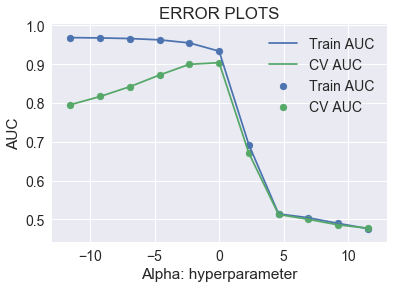

In [15]:
train_auc = []
cv_auc = []
#performing simple cross-validation
for alpha in alphas:
    clf = MultinomialNB(alpha = alpha)
    clf.fit(x_train, y_train)
    y_train_pred = []
    y_cv_pred = []
    for i in range(0, x_train.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(x_train[i:i+1000,:])[:,1])
    for i in range(0, x_cv.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(x_cv[i:i+1000,:])[:,1])
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.scatter(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.scatter(log_alphas, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [16]:
optimal_alpha = 1e+0
bow_fe_alpha = optimal_alpha

The accuracy for k = 1.0 using simple crossvalidation for BOW is 90.615


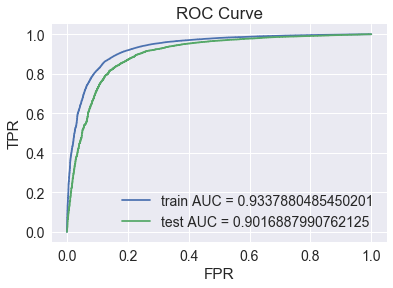

Confusion Matrix : 


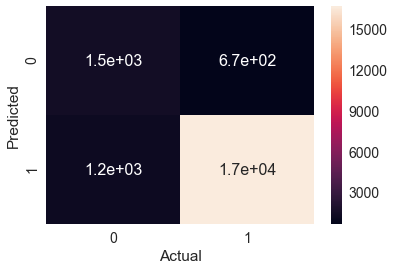

In [17]:
clf_for_optimal_alpha = MultinomialNB(alpha = optimal_alpha)
clf_for_optimal_alpha.fit(x_train, y_train)
x_test = count_vect.transform(x_test_raw)
x_test = scipy.sparse.hstack((x_test, np.array(final_data['Length_of_Cleaned_Text'])[80000:100000,None]))
x_test = scipy.sparse.hstack((x_test, np.array(final_data['Sentiment'])[80000:100000,None]))
x_test = x_test.tocsr()
y_test_pred = []
y_train_pred_proba = []
y_test_pred_proba = []
for i in range(0, x_train.shape[0], 1000):
    y_train_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_train[i:i+1000])[:,1]) # To build ROC curve
for i in range(0,x_test.shape[0], 1000):
    y_test_pred.extend(clf_for_optimal_alpha.predict(x_test[i:i+1000,:])) # To find Accuracy
    y_test_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_test[i:i+1000])[:,1]) # To build ROC curve

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
acc = accuracy_score(y_test,y_test_pred)*100.0
print('The accuracy for k = {} using simple crossvalidation for BOW is {}'.format(optimal_alpha, acc))

bow_new_train_auc = auc(train_fpr, train_tpr)
bow_new_test_auc = auc(test_fpr, test_tpr)
plt.plot(train_fpr, train_tpr, label = 'train AUC = '+str(bow_new_train_auc))
plt.plot(test_fpr, test_tpr, label = 'test AUC = '+str(bow_new_test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

print('Confusion Matrix : ')
matrix = confusion_matrix(y_test,y_test_pred).T
ax = sns.heatmap(matrix, annot = True, annot_kws = {'size' : 16})
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

## TFIDF

### Trainning

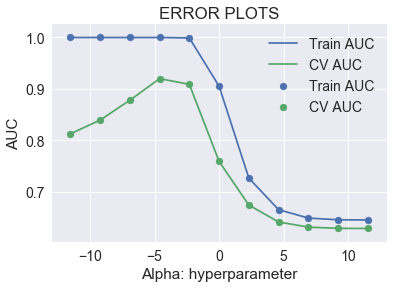

In [18]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
tf_idf_vect.fit(x_train_raw.values)
x_train = tf_idf_vect.transform(x_train_raw.values)
x_cv = tf_idf_vect.transform(x_cv_raw)
train_auc = []
cv_auc = []
#performing simple cross-validation
for alpha in alphas:
    clf = MultinomialNB(alpha = alpha)
    clf.fit(x_train, y_train)
    y_train_pred = []
    y_cv_pred = []
    for i in range(0, x_train.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(x_train[i:i+1000,:])[:,1])
    for i in range(0, x_cv.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(x_cv[i:i+1000,:])[:,1])
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.scatter(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.scatter(log_alphas, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Testing

The accuracy for k = 0.01 using simple crossvalidation for TFIDF is 89.235


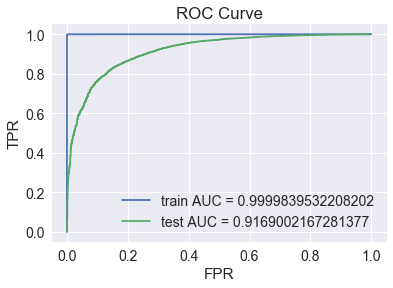

Confusion Matrix : 


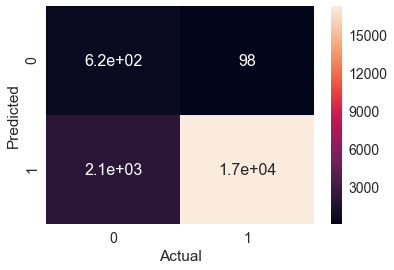

In [19]:
optimal_alpha = 1e-2
tfidf_alpha = optimal_alpha
clf_for_optimal_alpha = MultinomialNB(alpha = optimal_alpha)
clf_for_optimal_alpha.fit(x_train, y_train)
x_test = tf_idf_vect.transform(x_test_raw)
y_test_pred = []
y_train_pred_proba = []
y_test_pred_proba = []
for i in range(0, x_train.shape[0], 1000):
    y_train_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_train[i:i+1000])[:,1]) # To build ROC curve
for i in range(0,x_test.shape[0], 1000):
    y_test_pred.extend(clf_for_optimal_alpha.predict(x_test[i:i+1000,:])) # To find Accuracy
    y_test_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_test[i:i+1000])[:,1]) # To build ROC curve

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
acc = accuracy_score(y_test,y_test_pred)*100.0
print('The accuracy for k = {} using simple crossvalidation for TFIDF is {}'.format(optimal_alpha, acc))

tfidf_train_auc = auc(train_fpr, train_tpr)
tfidf_test_auc = auc(test_fpr, test_tpr)
plt.plot(train_fpr, train_tpr, label = 'train AUC = '+str(tfidf_train_auc))
plt.plot(test_fpr, test_tpr, label = 'test AUC = '+str(tfidf_test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

print('Confusion Matrix : ')
matrix = confusion_matrix(y_test,y_test_pred).T
ax = sns.heatmap(matrix, annot = True, annot_kws = {'size' : 16})
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

### Top 10 important features of positive class


In [20]:
top10_indexes = clf_for_optimal_alpha.feature_log_prob_[1].argsort()[-10:][::-1]
list_of_features = tf_idf_vect.get_feature_names()
print('Feature : Log Probability')
for index in top10_indexes:
    print('{} : {}'.format(list_of_features[index], clf_for_optimal_alpha.feature_log_prob_[1][index]))

Feature : Log Probability
tea : -6.075778706042949
great : -6.155019496358137
tast : -6.217224980634806
love : -6.235356236207036
good : -6.238867752640111
like : -6.256937628010221
flavor : -6.328992289309156
product : -6.395044229606836
use : -6.458816046500048
one : -6.531484711154619


### Top 10 important features of negative class


In [21]:
top10_indexes = clf_for_optimal_alpha.feature_log_prob_[0].argsort()[-10:][::-1]
list_of_features = tf_idf_vect.get_feature_names()
print('Feature : Log Probability')
for index in top10_indexes:
    print('{} : {}'.format(list_of_features[index], clf_for_optimal_alpha.feature_log_prob_[0][index]))

Feature : Log Probability
tast : -6.063768376661451
like : -6.185235307510944
product : -6.195417611985389
would : -6.515286939510599
one : -6.557063011633133
flavor : -6.5960230583234525
tri : -6.695624384391026
order : -6.705743256184558
buy : -6.71887899533024
tea : -6.752544346620777


### Feature Engineering

In [22]:
# Adding 2 new features calculated above to the dataset
x_train = scipy.sparse.hstack((x_train, np.array(final_data['Length_of_Cleaned_Text'])[:60000,None]))
x_train = scipy.sparse.hstack((x_train, np.array(final_data['Sentiment'])[:60000,None]))
x_train = x_train.tocsr()
x_cv = scipy.sparse.hstack((x_cv, np.array(final_data['Length_of_Cleaned_Text'])[60000:80000,None]))
x_cv = scipy.sparse.hstack((x_cv, np.array(final_data['Sentiment'])[60000:80000,None]))
x_cv = x_cv.tocsr()

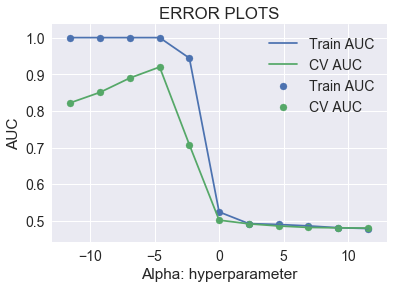

In [23]:
train_auc = []
cv_auc = []
#performing simple cross-validation
for alpha in alphas:
    clf = MultinomialNB(alpha = alpha)
    clf.fit(x_train, y_train)
    y_train_pred = []
    y_cv_pred = []
    for i in range(0, x_train.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(x_train[i:i+1000,:])[:,1])
    for i in range(0, x_cv.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(x_cv[i:i+1000,:])[:,1])
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.scatter(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.scatter(log_alphas, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

The accuracy for k = 0.01 using simple crossvalidation for Tfidf is 89.255


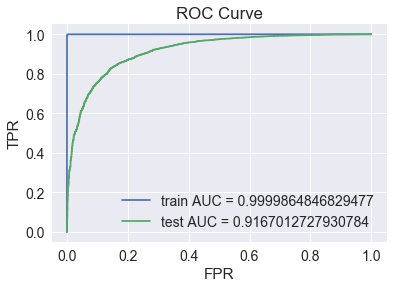

Confusion Matrix : 


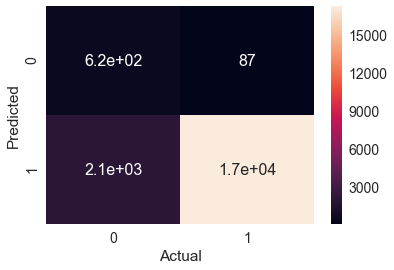

In [28]:
optimal_alpha = 1e-2
tfidf_fe_alpha = optimal_alpha
clf_for_optimal_alpha = MultinomialNB(alpha = optimal_alpha)
clf_for_optimal_alpha.fit(x_train, y_train)
clf_for_optimal_alpha = MultinomialNB(alpha = optimal_alpha)
clf_for_optimal_alpha.fit(x_train, y_train)
x_test = tf_idf_vect.transform(x_test_raw)
x_test = scipy.sparse.hstack((x_test, np.array(final_data['Length_of_Cleaned_Text'])[80000:100000,None]))
x_test = scipy.sparse.hstack((x_test, np.array(final_data['Sentiment'])[80000:100000,None]))
x_test = x_test.tocsr()
y_test_pred = []
y_train_pred_proba = []
y_test_pred_proba = []
for i in range(0, x_train.shape[0], 1000):
    y_train_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_train[i:i+1000])[:,1]) # To build ROC curve
for i in range(0,x_test.shape[0], 1000):
    y_test_pred.extend(clf_for_optimal_alpha.predict(x_test[i:i+1000,:])) # To find Accuracy
    y_test_pred_proba.extend(clf_for_optimal_alpha.predict_proba(x_test[i:i+1000])[:,1]) # To build ROC curve

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
acc = accuracy_score(y_test,y_test_pred)*100.0
print('The accuracy for k = {} using simple crossvalidation for Tfidf is {}'.format(optimal_alpha, acc))

tfidf_new_train_auc = auc(train_fpr, train_tpr)
tfidf_new_test_auc = auc(test_fpr, test_tpr)
plt.plot(train_fpr, train_tpr, label = 'train AUC = '+str(tfidf_new_train_auc))
plt.plot(test_fpr, test_tpr, label = 'test AUC = '+str(tfidf_new_test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

print('Confusion Matrix : ')
matrix = confusion_matrix(y_test,y_test_pred).T
ax = sns.heatmap(matrix, annot = True, annot_kws = {'size' : 16})
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

# Conclusions

In [29]:
p = PrettyTable(field_names = ['Vectorizer', 'Model', 'Hyper Parameter(alpha)', 'Train AUC', 'Test AUC'])

p.add_row(['BOW', 'Brute', bow_alpha, bow_train_auc, bow_test_auc])
p.add_row(['BOW', 'Brute + Feature Engineering', bow_fe_alpha, bow_new_train_auc, bow_new_test_auc])
p.add_row(['TFIDF', 'Brute', tfidf_alpha, tfidf_train_auc, tfidf_test_auc])
p.add_row(['TFIDF', 'Brute + Feature Engineering', tfidf_fe_alpha, tfidf_new_train_auc, tfidf_new_test_auc])

print(p)

+------------+-----------------------------+------------------------+--------------------+--------------------+
| Vectorizer |            Model            | Hyper Parameter(alpha) |     Train AUC      |      Test AUC      |
+------------+-----------------------------+------------------------+--------------------+--------------------+
|    BOW     |            Brute            |           1            | 0.931247950068233  | 0.8973173860776946 |
|    BOW     | Brute + Feature Engineering |          1.0           | 0.9337880485450201 | 0.9016887990762125 |
|   TFIDF    |            Brute            |          0.01          | 0.9999839532208202 | 0.9169002167281377 |
|   TFIDF    | Brute + Feature Engineering |          0.01          | 0.9999864846829477 | 0.9167012727930784 |
+------------+-----------------------------+------------------------+--------------------+--------------------+
